In [ ]:
! pip uninstall opencv-python
! pip uninstall opencv-contrib-python

! pip install opencv-python==3.4.2.17
! pip install opencv-contrib-python==3.4.2.17

In [2]:
import skimage
import skimage.io as io
import skimage.exposure as skexp
import skimage.color as color
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import inspect
from math import log, exp
from scipy.optimize import minimize, fmin
import gdown

In [48]:
LINKS = {
    'input': 'https://drive.google.com/uc?id=1f_ClnQ9fh6mRVGRkNV2kq9l4b_rWbF5d',
    'ref': 'https://drive.google.com/uc?id=1Cx8XP0or7HGGa6vn2pFSKgt6I3tiDWtA',
    'mask': 'https://drive.google.com/uc?id=1DMxt81HF102Oh2bUg4wloUFBCcHdptcN'
}

In [ ]:
ref_output = 'ref.jpg'
gdown.download(LINKS['ref'], ref_output)

input_output = 'input.jpg'
gdown.download(LINKS['input'], input_output)

mask_output = 'mask.png'
gdown.download(LINKS['mask'], mask_output)

In [50]:
ref_image = cv.imread('ref.jpg')
ref_image = cv.cvtColor(ref_image, cv.COLOR_BGR2RGB)

input_file_name = 'input'
input_image = cv.imread(f'{input_file_name}.jpg')
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)

ref_mask = cv.imread('mask.png')

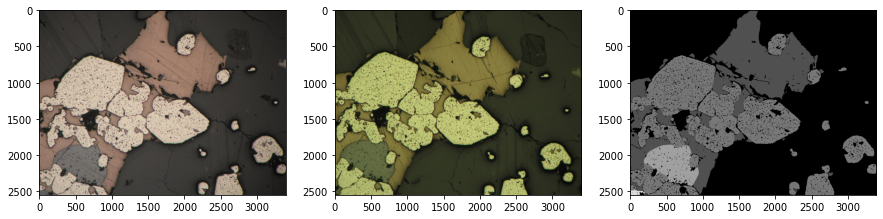

In [51]:
f, axarr = plt.subplots(1,3, figsize=(15,15))
axarr[0].imshow(ref_image)
axarr[1].imshow(input_image)
axarr[2].imshow(ref_mask * 20, 'gray')

### Template matching

In [17]:
MIN_MATCH_COUNT = 2

def get_matched_coordinates(temp_img, map_img):
    """
    Gets template and map image and returns matched coordinates in map image

    Parameters
    ----------
    temp_img: image
        image to be used as template

    map_img: image 
        image to be searched in

    Returns
    ---------
    ndarray
        an array that contains matched coordinates

    """

    # initiate SIFT detector
    sift = cv.xfeatures2d.SIFT_create(nfeatures = 0, 
                                      nOctaveLayers = 3,
                 	                  contrastThreshold = 0.04,
                 	                  edgeThreshold = 10,
                                      sigma = 10 )

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(temp_img, None)
    kp2, des2 = sift.detectAndCompute(map_img, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv.FlannBasedMatcher(index_params, search_params)

    # find matches by knn which calculates point distance in 128 dim
    matches = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32(
            [kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32(
            [kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # find homography
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 10, confidence=0.7)
        matchesMask = mask.ravel().tolist()

        h, w = temp_img.shape
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1],
                          [w-1, 0]]).reshape(-1, 1, 2)
        dst = cv.perspectiveTransform(pts, M)  # matched coordinates

        map_img = cv.polylines(
            map_img, [np.int32(dst)], True, 255, 3, cv.LINE_AA)

    else:
        print("Not enough matches are found - %d/%d" %
              (len(good), MIN_MATCH_COUNT))
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # draw only inliers
                       flags=2)

    # draw template and map image, matches, and keypoints
    img3 = cv.drawMatches(temp_img, kp1, map_img, kp2,
                           good, None, **draw_params)

    plt.imshow(img3, 'gray'), plt.show()

    # result image path
    cv.imwrite('result.png', img3)

    return dst, M

### Implementation of template matching

Unique minerals =  5065038


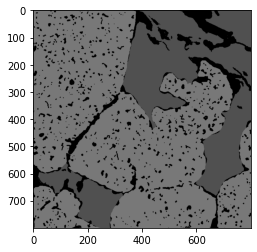

In [63]:
h, w, _ = ref_mask.shape

TEMPLATE_SIZE = 800

templates_horizontally = w // TEMPLATE_SIZE 
templates_vertically = h // TEMPLATE_SIZE 

max_unique = 0
max_j = 1
max_i = 1

for i in range (1, templates_horizontally):
    for j in range (1, templates_vertically):
        curr_mask = ref_mask[j*TEMPLATE_SIZE: (j+1) * TEMPLATE_SIZE, i*TEMPLATE_SIZE : (i+1)*TEMPLATE_SIZE]
        unique_count = len(np.unique(curr_mask)) * np.count_nonzero(curr_mask)
        if unique_count > max_unique:
            max_unique = unique_count
            max_i = i
            max_j = j

print("Unique minerals = ", max_unique)
mask_template = ref_mask[max_j*TEMPLATE_SIZE: (max_j+1) * TEMPLATE_SIZE, max_i*TEMPLATE_SIZE : (max_i+1)*TEMPLATE_SIZE]
plt.imshow(mask_template * 20)

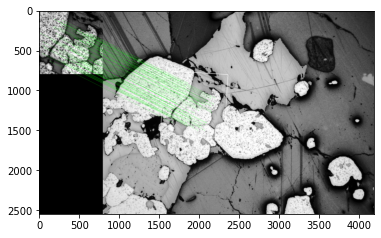

In [64]:
input_img_gray = cv.cvtColor(input_image, cv.COLOR_BGR2GRAY)
ref_img_gray = cv.cvtColor(ref_image, cv.COLOR_BGR2GRAY)

temp_img_gray = ref_img_gray[max_j*TEMPLATE_SIZE: (max_j+1) * TEMPLATE_SIZE, max_i*TEMPLATE_SIZE : (max_i+1)*TEMPLATE_SIZE]

temp_img_eq = cv.equalizeHist(temp_img_gray)
map_img_eq = cv.equalizeHist(input_img_gray)

coord, M = get_matched_coordinates(temp_img_eq, map_img_eq)

In [65]:
rgb_template = ref_image[max_j*TEMPLATE_SIZE: (max_j+1) * TEMPLATE_SIZE, max_i*TEMPLATE_SIZE : (max_i+1)*TEMPLATE_SIZE]

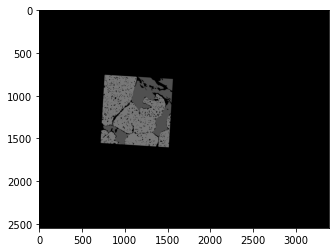

In [66]:
transformed_im = cv.warpPerspective(rgb_template, M, dsize=(input_img_gray.shape[1],input_img_gray.shape[0]))[:,:,0:3]
transformed_mask = cv.warpPerspective(mask_template, M, dsize=(input_img_gray.shape[1],input_img_gray.shape[0]))[:,:,0:3]
plt.imshow(transformed_mask * 20)

In [67]:
coord[coord < 0] = 0

down_y = np.array([coord[1][0][1], coord[2][0][1]])
up_y = np.array([coord[0][0][1], coord[3][0][1]])

left_x = np.array([coord[0][0][0], coord[1][0][0]])
right_x = np.array([coord[2][0][0], coord[3][0][0]])

a = round(left_x.max())
b = round(up_y.max())
c = round(right_x.min())
d = round(down_y.min())

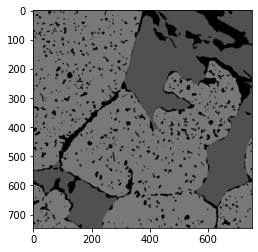

In [68]:
cropped_transformed_template = transformed_im[b:d,a:c]
cropped_transformed_mask = transformed_mask[b:d,a:c]
plt.imshow(cropped_transformed_mask * 20, 'gray')

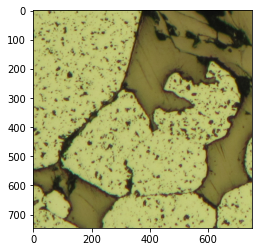

In [69]:
cropped_input_image = input_image[b:d,a:c]
plt.imshow(cropped_input_image)

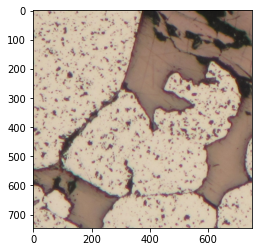

In [70]:
plt.imshow(cropped_transformed_template)

### Extracting color spaces

In [71]:
result_mask = cropped_transformed_mask[:,:,0]
result_ref = cropped_transformed_template
result_input = cropped_input_image

In [72]:
ref_colors = np.empty((0,3), float)
input_colors = np.empty((0,3), float)

unique_minerals = np.unique(result_mask)

for mineral in unique_minerals:
    check_mineral_mask = np.copy(result_mask)
    count = len(check_mineral_mask[check_mineral_mask == mineral])
    if count < 0.1 * TEMPLATE_SIZE * TEMPLATE_SIZE:
        unique_minerals = np.delete(unique_minerals, np.argwhere(unique_minerals == mineral)[0])


for mineral in unique_minerals:
    R_ref_color = np.mean(result_ref[:, :, 0][result_mask == mineral])
    B_ref_color = np.mean(result_ref[:, :, 2][result_mask == mineral])
    G_ref_color = np.mean(result_ref[:, :, 1][result_mask == mineral])
    ref_color = np.array([[R_ref_color, G_ref_color, B_ref_color]])
    R_input_color = np.mean(result_input[:, :, 0][result_mask == mineral])
    B_input_color = np.mean(result_input[:, :, 2][result_mask == mineral])
    G_input_color = np.mean(result_input[:, :, 1][result_mask == mineral])
    input_color = np.array([[R_input_color, G_input_color, B_input_color]])
    ref_colors = np.append(ref_colors, ref_color, axis=0)
    input_colors = np.append(input_colors, input_color, axis=0)

### Color Calibration 

#### Distance

In [28]:
### DISTANCE ###

def distance_de00(src_lab, dst_lab):
    return color.deltaE_ciede2000(src_lab, dst_lab)

def distance_de94(src_lab, dst_lab):
    return color.deltaE_ciede94(src_lab, dst_lab)

def distance_de76(src_lab, dst_lab):
    return color.deltaE_cie76(src_lab, dst_lab)

distance_rgbl = distance_rgb = distance_de76

def distance_cmc(src_lab, dst_lab):
    return color.deltaE_cmc(src_lab, dst_lab)

#### Utils

In [29]:
### UTILS ###

def saturate(src, low, up):
    '''return the mask of unsaturated colors'''
    return np.all(np.logical_and(src>=low,src<=up), axis = -1)               

def gamma_correction(rgb, gamma):
    '''
    gamma correction; 
    see ColorSpace.pdf for details;
    '''
    
    arr = rgb.copy()
    mask = rgb>=0
    arr[mask] = np.power(arr[mask], gamma)
    arr[~mask] = -np.power(-arr[~mask], gamma)
    return arr

def rgb2gray(rgb):
    '''
    it is an approximation grayscale function for relative RGB color space;
    see Miscellaneous.pdf for details;
    rgb->gray
    '''
    return rgb@np.array([0.2126, 0.7152, 0.0722])


#### IO

In [30]:
### IO ###

class IO:
    '''
    io: illuminant & observer;
    see notes of api.py for supported list for io; 
    '''
    def __init__(self, illuminant, observer):
        self.illuminant = illuminant
        self.observer = observer
    
    def __eq__(self, other):
        return self.illuminant==other.illuminant and self.observer==other.observer
    
    def __hash__(self):
        return hash(self.illuminant+self.observer)
    
    def __repr__(self):
        return f"{self.illuminant}_{self.observer}"

A_2 = IO("A", "2")
A_10 = IO("A", "10")
D50_2 = IO("D50", "2")
D50_10 = IO("D50", "10")
D55_2 = IO("D55", "2")
D55_10 = IO("D55", "10")
D65_2 = IO("D65", "2")
D65_10 = IO("D65", "10")
D75_2 = IO("D75", "2")
D75_10 = IO("D75", "10")
E_2 = IO("E", "2")
E_10 = IO("E", "10")

def xyY2XYZ(x,y,Y=1):
    '''xyY to XYZ'''
    X = Y*x/y
    Z = Y/y*(1-x-y)
    return np.array([X,Y,Z])
    
'''data from https://en.wikipedia.org/wiki/Standard_illuminant'''
illuminants_xy = \
    {A_2: (0.44757, 0.40745),
    A_10: (0.45117, 0.40594),
    D50_2: (0.34567, 0.35850),
    D50_10: (0.34773, 0.35952),
    D55_2: (0.33242, 0.34743),
    D55_10: (0.33411, 0.34877),
    D65_2: (0.31271, 0.32902),  
    D65_10: (0.31382, 0.33100),
    D75_2: (0.29902, 0.31485),
    D75_10: (0.29968, 0.31740),
    E_2: (1/3, 1/3),
    E_10: (1/3, 1/3)}

def get_illuminant():
    '''get illuminants'''

    illuminants = {}
    for io, (x, y) in illuminants_xy.items():
        illuminants[io] = xyY2XYZ(x, y)

    # data from https://en.wikipedia.org/wiki/Illuminant_D65
    illuminants[D65_2]=np.array([0.95047, 1., 1.08883])
    illuminants[D65_10]=np.array([0.94811, 1., 1.07304])
    return illuminants

# illuminants
illuminants = get_illuminant()

#### Colorspace

In [31]:
### COLORSPACE ###

class SingletonArgs(type):
    """ 
    Singleton with arguments;
    Only supports hashable arguments.
    """
    _instances = {}

    def __call__(cls, *args, **kwargs):
        key = (cls, frozenset(inspect.getcallargs(cls.__init__, None, *args, **kwargs).items()))

        if key not in cls._instances:
            cls._instances[key] = super(SingletonArgs, cls).__call__(*args, **kwargs)
        return cls._instances[key]

class ColorSpace(metaclass=SingletonArgs):
    '''color space interface'''
    def __init__(self):
        self.io = None
    
    def relate(self, other):
        '''
        relate with other color space;
        if they are the same, return copy function;
        else return None;
        '''
        return (lambda x:x) if type(self)==type(other) and self.io==other.io else None

class RGB_Base_(ColorSpace):
    '''
    base of RGB color space;
    the argument values are from AdobeRGB;

    Data from https://en.wikipedia.org/wiki/Adobe_RGB_color_space
    '''
    def __init__(self, linear = False):
        self._set_primaries()
        self._cal_M()

        self._set_gamma()
        self._cal_para()

        self.linear = linear
        self.operations()

    def _set_primaries(self):
        # IO
        self.io = D65_2        

        # primaries
        self.xr, self.yr = 0.64, 0.33
        self.xg, self.yg = 0.21, 0.71
        self.xb, self.yb = 0.15, 0.06

    def _set_gamma(self):
        # linearization
        self.gamma = 2.2  
    
    def _cal_para(self):
        pass

    def operations(self):
        '''operations to or from XYZ'''
        if self.linear:
            self.to = [self.M.T]
            self.from_ = [self.Mi.T]
        else:
            self.to = [self.toL, self.M.T]
            self.from_ = [self.Mi.T, self.fromL]

    def _cal_M(self):
        '''
        calculation of M_RGBL2XYZ_base;
        see ColorSpace.pdf for details;
        '''
        XYZr = xyY2XYZ(self.xr, self.yr)
        XYZg = xyY2XYZ(self.xg, self.yg)
        XYZb = xyY2XYZ(self.xb, self.yb)
        XYZw = illuminants[self.io]
        XYZ_rgbl = np.stack([XYZr, XYZg, XYZb], axis= 1)
        Sr, Sg, Sb = np.linalg.solve(XYZ_rgbl, XYZw)
        self.M = np.stack([Sr*XYZr, Sg*XYZg, Sb*XYZb], axis= 1) 
        self.Mi = np.linalg.inv(self.M)

    def toL(self, rgb):
        '''rgb -> rgbl'''
        return gamma_correction(rgb, self.gamma)
    
    def fromL(self, rgbl):
        '''rgbl -> rgb'''
        return gamma_correction(rgbl, 1/self.gamma)

    def relate(self, other):
        '''
        There are 3 kinds of relationships for RGB:
         1. Different types;    - no operation
         1. Same type, same linear; - copy
         2. Same type, different linear, self is nonlinear; - 2 toL
         3. Same type, different linear, self is linear - 3 fromL
        '''
        if type(self)!=type(other):
            return None
        if self.linear==other.linear:
            return (lambda x:x)
        if self.linear==False:
            return self.toL
        return self.fromL    

class sRGB_Base_(RGB_Base_):
    '''
    base of sRGB-like color space;
    the argument values are from sRGB;
    data from https://en.wikipedia.org/wiki/SRGB
    '''
    def _set_primaries(self):
        # IO
        self.io = D65_2        
        # primaries
        self.xr, self.yr = 0.64, 0.33	
        self.xg, self.yg = 0.30, 0.60
        self.xb, self.yb = 0.15, 0.06

    def _set_gamma(self):
        # linearization
        self.a = 0.055
        self.gamma = 2.4

    def _cal_para(self):
        '''
        linearization parameters
        see ColorSpace.pdf for details;        
        '''
        self.alpha = self.a+1
        self.K0 = self.a/(self.gamma-1)
        self.phi = (self.alpha**self.gamma*(self.gamma-1)**(self.gamma-1))/(self.a**(self.gamma-1)*self.gamma**self.gamma)
        self.beta = self.K0/self.phi

    def toL(self, rgb):
        '''
        linearization
        see ColorSpace.pdf for details; 
        '''
        def _rgb2rgbl_ele(x):
            if x>self.K0:
                return ((x+self.alpha-1)/self.alpha)**self.gamma
            elif x>=-self.K0:
                return x/self.phi
            else:
                return -(((-x+self.alpha-1)/self.alpha)**self.gamma)
        return np.vectorize(_rgb2rgbl_ele)(rgb)  
    
    def fromL(self, rgbl):
        '''
        delinearization
        see ColorSpace.pdf for details; 
        '''
        def _rgbl2rgb_ele(x):
            if x>self.beta:
                return self.alpha*(x**(1/self.gamma))-(self.alpha-1)
            elif x>=-self.beta:
                return x*self.phi
            else:
                return -(self.alpha*((-x)**(1/self.gamma))-(self.alpha-1))
        return np.vectorize(_rgbl2rgb_ele)(rgbl)    

class sRGB_(sRGB_Base_):
    '''data from https://en.wikipedia.org/wiki/SRGB'''
    pass

class AdobeRGB_(RGB_Base_):
    pass

class WideGamutRGB_(RGB_Base_):
    '''data from https://en.wikipedia.org/wiki/Wide-gamut_RGB_color_space'''

    def _set_primaries(self):
        self.xr, self.yr = 0.7347, 0.2653	
        self.xg, self.yg = 0.1152, 0.8264
        self.xb, self.yb = 0.1566, 0.0177
        self.io = D50_2

class ProPhotoRGB_(RGB_Base_):
    '''data from https://en.wikipedia.org/wiki/ProPhoto_RGB_color_space'''

    def _set_primaries(self):
        self.xr, self.yr = 0.734699, 0.265301	
        self.xg, self.yg = 0.159597, 0.840403
        self.xb, self.yb = 0.036598, 0.000105
        self.io = D50_2    

    def _set_gamma(self):
        self.gamma = 1.8

class DCI_P3_RGB_(RGB_Base_):
    '''data from https://en.wikipedia.org/wiki/DCI-P3'''

    def _set_primaries(self):
        self.xr, self.yr = 0.680, 0.32	
        self.xg, self.yg = 0.265, 0.69
        self.xb, self.yb = 0.15, 0.06
        self.io = D65_2        

class AppleRGB_(RGB_Base_):
    '''data from http://www.brucelindbloom.com/index.html?WorkingSpaceInfo.html'''

    def _set_primaries(self):   	
        self.xr, self.yr = 0.625, 0.34	
        self.xg, self.yg = 0.28, 0.595
        self.xb, self.yb = 0.155, 0.07
        self.io = D65_2        
    
    def _set_gamma(self):
        self.gamma = 1.8

class REC_709_RGB_(sRGB_Base_):
    '''data from https://en.wikipedia.org/wiki/Rec._709'''

    def _set_primaries(self):   	
        self.xr, self.yr = 0.64, 0.33	
        self.xg, self.yg = 0.3, 0.6
        self.xb, self.yb = 0.15, 0.06
        self.io = D65_2        
    
    def _set_gamma(self):
        self.a, self.gamma = 0.099, 1/0.45
 
class REC_2020_RGB_(sRGB_Base_):
    '''data from https://en.wikipedia.org/wiki/Rec._2020'''

    def _set_primaries(self):   	
        self.xr, self.yr = 0.708, 0.292	
        self.xg, self.yg = 0.17, 0.797
        self.xb, self.yb = 0.131, 0.046
        self.io = D65_2  

    def _set_gamma(self):
        self.a, self.gamma = 0.09929682680944, 1/0.45    

def bind(CS):
    '''produce color space instance with linear and non-linear versions'''
    cs, csl = CS(), CS(True)
    cs.l = csl.l = csl
    csl.nl = cs.nl = cs
    return cs, csl

sRGB, sRGBL = bind(sRGB_)
AdobeRGB, AdobeRGBL = bind(AdobeRGB_)
WideGamutRGB, WideGamutRGBL = bind(WideGamutRGB_)
ProPhotoRGB, ProPhotoRGBL = bind(ProPhotoRGB_)
DCI_P3_RGB, DCI_P3_RGBL = bind(DCI_P3_RGB_)
AppleRGB, AppleRGBL = bind(AppleRGB_)
REC_709_RGB, REC_709_RGBL = bind(REC_709_RGB_)
REC_2020_RGB, REC_2020_RGBL = bind(REC_2020_RGB_)

class XYZ(ColorSpace):
    '''chromatic adaption matrices'''
    CAMs = {}

    Von_Kries = np.array([[ 0.40024,  0.7076 , -0.08081],
                    [-0.2263 ,  1.16532,  0.0457 ],
                    [ 0.     ,  0.     ,  0.91822]])

    Bradford = np.array([[0.8951, 0.2664, -0.1614],
            [-0.7502, 1.7135, 0.0367],
            [0.0389, -0.0685, 1.0296]])

    MAs = {'Identity':(np.eye(3), np.eye(3)), 
        'Von_Kries':(Von_Kries, np.linalg.inv(Von_Kries)),
        'Bradford':(Bradford, np.linalg.inv(Bradford))}

    @classmethod
    def _cam(cls, sio, dio, method = 'Bradford'):
        '''get cam'''
        if sio==dio:
            return np.eye(3)
        if (sio, dio, method) in cls.CAMs:
            return cls.CAMs[(sio, dio, method)]
        if (dio, sio, method) in cls.CAMs:
            cls.CAMs[(sio, dio, method)] = np.linalg.inv(cls.CAMs[(dio, sio, method)])
            return cls.CAMs[(sio, dio, method)]
        # function from http://www.brucelindbloom.com/index.html?ColorCheckerRGB.html
        XYZws = illuminants[sio]
        XYZWd = illuminants[dio]
        MA, MA_inv = cls.MAs[method]
        M = MA_inv@np.diag((MA@XYZWd)/(MA@XYZws))@MA
        cls.CAMs[(sio, dio, method)] = M
        return M

    def __init__(self, io = D65_2):
        self.io = io
        self.to = []
        self.from_ = []

    def cam(self, io, method = 'Bradford'):
        return [] if self.io == io else [self._cam(self.io, io, method).T]
        
XYZ_D65_2 = XYZ()
XYZ_D50_2 = XYZ(D50_2)

from functools import partial
class Lab(ColorSpace):
    def __init__(self, io = D65_2):
        self.io = io
        
        self.to = [partial(color.colorconv.lab2xyz, illuminant = self.io.illuminant, 
            observer = self.io.observer)]
        
        self.from_ = [partial(color.colorconv.xyz2lab, illuminant = self.io.illuminant, 
            observer = self.io.observer)]

# from copy import copy
Lab_D65_2 = Lab()
Lab_D50_2 = Lab(D50_2)

#### Color

In [32]:
### COLOR ###

class Color:
    def __init__(self, colors, cs):
        '''
        color defined by color_values and color space;
        self.grays is mask of grayscale color;
        self.colored is mask of colored color;
        self._history is storage of historical conversion;
        '''
        self.colors = colors
        self.cs = cs
        self.grays = None
        self.colored = None
        self._history = {}
        
    def to(self, cs, method = 'Bradford', save=True):
        '''
        change to other color space; return Color;
        The conversion process incorporates linear transformations to speed up.
        method is chromatic adapation method;
        when save if True, get data from self._history first;
        '''
        def do_operation(colors, operations):
            M = None
            for op in operations:
                if isinstance(op, np.ndarray):
                    if M is None:
                        M = op
                    else:
                        M = M@op
                else:
                    if M is not None:
                        colors = colors@M
                        M = None
                    colors = op(colors)
            if M is not None:
                colors = colors@M
            return colors

        if cs in self._history:
            return self._history[cs]
        f = self.cs.relate(cs)
        if f:
            return Color(f(self.colors), cs)
        
        operations = [*self.cs.to, *(XYZ(self.cs.io).cam(cs.io, method)), *cs.from_]
        colors = do_operation(self.colors, operations)
        color = Color(colors, cs)
        if save:
            self._history[cs] = color
        return color

    def toGray(self, io, method = 'Bradford', save=True):
        '''self.cs -> gray'''
        return self.to(XYZ(io), method, save).colors[...,1]

    def toLuminant(self, io, method = 'Bradford', save=True):
        '''self.cs -> L*'''
        return self.to(Lab(io), method, save).colors[...,0]

    def get_gray(self, JDN=2):
        '''calculate gray mask'''
        if self.grays is not None:
            return
        color = self.to(Lab_D65_2).colors
        L = color[..., 0]
        a, b = np.zeros(L.shape), np.zeros(L.shape)
        gray = np.stack([L, a, b], axis=-1)
        dis = distance_de00(color, gray)
        self.grays = (dis<JDN)
        self.colored = ~self.grays
    
    def diff(self, other, method='de00', io = None, DEBUG = False):
        '''return distance between self and other'''
        if not io: 
            io=self.cs.io
        if method in ['de00', 'de94', 'de76', 'cmc']:
            if DEBUG:
                print('to_lab: ', self.to(Lab(io)).colors)
                print('other_lab: ',other.to(Lab(io)).colors)
            return globals()['distance_'+method](self.to(Lab(io)).colors, other.to(Lab(io)).colors)
        elif method in ['rgb']:
            return globals()['distance_'+method](self.to(self.cs.nl).colors, other.to(self.cs.nl).colors)
        elif method in ['rgbl']:
            return globals()['distance_'+method](self.to(self.cs.l).colors, other.to(self.cs.l).colors)

    def __getitem__(self, mask):
        '''return masked color'''
        return Color(self.colors[mask],self.cs)

#### Linearization

In [33]:
class Polyfit:
    '''
    Polyfit model;
    see Linearization.py for details;
    '''
    def __init__(self, s, d, deg):
        p = np.polyfit(s, d, deg)
        self.p = np.poly1d(p)
    
    def __call__(self, inp):
        return self.p(inp)

class Logpolyfit:
    '''
    Logpolyfit model;
    see Linearization.py for details;
    '''
    def __init__(self, s, d, deg):
        mask = (s>0) & (d>0)
        s = s[mask]
        d = d[mask]
        self.p = np.poly1d(np.polyfit(np.log(s), np.log(d), deg))
    
    def __call__(self, inp):
        mask = inp>0
        output = inp.copy()
        output[mask] = np.exp(self.p(np.log(output[mask])))
        output[~mask] = 0
        return output


class Linear:
    '''linearization base'''
    def __init__(self, *args):
        '''get args'''
        pass

    def calc(self):
        '''calculate parameters'''
        pass

    def linearize(self, inp):
        '''inference'''
        return inp
    
    def value(self):
        '''evaluate linearization model'''
        pass

class Linear_identity(Linear):
    '''make no change'''
    pass

class Linear_gamma(Linear):
    '''
    gamma correction;
    see Linearization.py for details;
    '''
    def __init__(self, gamma, *_):
        self.gamma = gamma

    def linearize(self, inp):
        return gamma_correction(inp, self.gamma)

class Linear_color_polyfit(Linear):
    '''
    polynomial fitting channels respectively;
    see Linearization.py for details;
    '''    
    method = Polyfit
    def __init__(self, _, deg, src, dst, mask, cs):
        self.deg = deg
        # mask = saturate(src, *saturated_threshold)
        self.src, self.dst = src[mask], dst.to(cs.l).colors[mask]
        self.calc()

    def calc(self):
        '''
        monotonically increase is not guaranteed;
        see Linearization.py for more details;
        '''
        rs, gs, bs = self.src[..., 0], self.src[..., 1], self.src[..., 2]
        rd, gd, bd = self.dst[..., 0], self.dst[..., 1], self.dst[..., 2]

        self.pr = self.method(rs, rd, self.deg)
        self.pg = self.method(gs, gd, self.deg)
        self.pb = self.method(bs, bd, self.deg)

    def linearize(self, inp):
        r, g, b = inp[..., 0], inp[..., 1], inp[..., 2]
        return np.stack([self.pr(r), self.pg(g), self.pb(b)], axis=-1)

class Linear_color_logpolyfit(Linear_color_polyfit):
    '''
    logarithmic polynomial fitting channels respectively;
    see Linearization.py for details;
    '''      
    method = Logpolyfit

class Linear_gray_polyfit(Linear):
    '''
    grayscale polynomial fitting;
    see Linearization.py for details;
    '''      
    method = Polyfit
    def __init__(self, _, deg, src, dst, mask, cs):
        self.deg = deg
        dst.get_gray()
        mask = mask & dst.grays

        # the grayscale function is approximate for src is in relative color space;
        # see Linearization.py for more details;
        self.src, self.dst = rgb2gray(src[mask]), dst.toGray(cs.io)[mask]
        self.calc()

    def calc(self):
        '''
        monotonically increase is not guaranteed;
        see Linearization.py for more details;
        '''        
        self.p = self.method(self.src, self.dst, self.deg)
        # self.p = np.poly1d(p)
        # print('p', self.p)

    def linearize(self, inp):
        return self.p(inp)

class Linear_gray_logpolyfit(Linear_gray_polyfit):
    '''
    grayscale logarithmic polynomial fitting;
    see Linearization.py for details;
    '''      
    method = Logpolyfit

#### Color correction matrix

In [34]:
class CCM_3x3:
    def __init__(self, src, dst, colorspace,
        distance, 
        linear, gamma, deg, 
        saturated_threshold, weights_list, weights_coeff, 
        initial_method, xtol, ftol):
        '''
        After being called, the method produce a CCM_3x3 instance (a color correction 
        model in fact) for inference.

        The meanings of the arguments have been detailed in api.py;
        '''

        # detected colors, the reference and the RGB colorspace for conversion
        self.src = src
        self.dst = dst
        self.cs = colorspace

        # linear method
        saturate_mask = saturate(src, *saturated_threshold)
        self.linear = globals()['Linear_'+linear](gamma, deg, src, self.dst, saturate_mask, self.cs)
        
        # weights and mask
        self.cal_weights_masks(weights_list, weights_coeff, saturate_mask)

        # RGBl of detected data and the reference
        self.src_rgbl = self.linear.linearize(self.src[self.mask])         
        self.dst = self.dst[self.mask]
        self.dst_rgbl = self.dst.to(self.cs.l).colors

        # the nonlinear optimization options:
        # 1. distance function
        self.distance = distance
        # 2. initial function
        self.inital_func = getattr(self, 'initial_' + initial_method)
        # 3. xtol and ftol
        self.xtol = xtol
        self.ftol = ftol
        # 4. the output
        self.ccm = None

        # empty for CCM_3x3, not empty for CCM_4x3
        # make __init__ method can also be used by CCM_4x3 class
        self.prepare()

        # distance function may affect the loss function and the fitting function
        if distance == 'rgbl':
            self.initial_least_square(fit=True)
        else:
            self.fitting()
        
    def cal_weights_masks(self, weights_list, weights_coeff, saturate_mask):
        '''calculate weights and mask'''
        # weights    
        self.weights = None 
        if weights_list is not None:
            self.weights = weights_list
        elif weights_coeff!=0:
            self.weights = np.power(self.dst.toLuminant(self.cs.io), weights_coeff)
        
        # masks
        weight_mask = np.ones(self.src.shape[0], dtype=bool)  
        if self.weights is not None:
            weight_mask = self.weights>0
        self.mask = saturate_mask & weight_mask

        # weights' mask
        if self.weights is not None:
            weights_masked = self.weights[self.mask]
            self.weights = weights_masked/np.mean(weights_masked)
        self.masked_len = np.sum(self.mask)        

    def prepare(self):
        '''make no change for CCM_3x3 class'''
        pass
    
    def initial_white_balance(self):
        '''
        fitting nonlinear-optimization initial value by white balance:
        res = diag(mean(s_r)/mean(d_r), mean(s_g)/mean(d_g), mean(s_b)/mean(d_b))
        see CCM.pdf for details;
        '''
        rs, gs, bs = np.sum(self.src_rgbl, axis = 0)
        rd, gd, bd = np.sum(self.dst_rgbl, axis = 0)
        return np.array([[rd/rs, 0, 0], [0, gd/gs, 0], [0, 0, bd/bs]]) 

    def initial_least_square(self, fit=False):
        '''
        fitting nonlinear-optimization initial value by least square:
        res = np.linalg.lstsq(src_rgbl, dst_rgbl)
        see CCM.pdf for details;
        if fit==True, return optimalization for rgbl distance function;
        '''        
        if self.weights is None: 
            ccm, r, *_ = np.linalg.lstsq(self.src_rgbl, self.dst_rgbl, rcond=None)
        else:
            w = (self.weights**0.5)[:, np.newaxis]
            ccm, r, *_  = np.linalg.lstsq(w*self.src_rgbl, w*self.dst_rgbl, rcond=None)
        if not fit:
            return ccm
        self.ccm = ccm
        self.error = np.sum(r) 
        print('ccm:', self.ccm)
        print('error:', self.error)           

    def loss(self, ccm, DEBUG = False):
        '''
        loss function;
        it is square-sum of color difference between src_rgbl@ccm and dst
        '''
        ccm = ccm.reshape((-1, 3))
        if DEBUG:
            print('src_rgbl: ', self.src_rgbl)
            print('ccm: ', ccm)
            print('converted: ', self.src_rgbl@ccm)
        dist = Color(self.src_rgbl@ccm, self.cs.l).diff(self.dst, self.distance, None, DEBUG)
        if DEBUG:
            print('dist: ', dist)
            print('dist.colors: ', Color(self.src_rgbl@ccm, self.cs.l).colors)
            print('lab', Color(self.src_rgbl@ccm, self.cs.l).to(Lab_D50_2).colors)
        dist = np.power(dist, 2)
        if self.weights is not None:
            dist = self.weights*dist
        return np.sum(dist)

    def fitting(self):
        '''fitting ccm if distance function is associated with CIE Lab color space'''
        ccm0 = self.inital_func()
        #loss0 = self.loss(ccm0)
        self.ccm0 = ccm0
        ccm0 = ccm0.reshape((-1))
        error0 = (self.loss(ccm0)/self.masked_len)**0.5
        print('error0:', error0)
        res = fmin(self.loss, ccm0, xtol = self.xtol, ftol = self.ftol)
        if res is not None:
            self.ccm = res.reshape((-1,3))
            self.error = (self.loss(res)/self.masked_len)**0.5
            print('ccm:', self.ccm)
            print('error:', self.error) 
            print('ccm0:', ccm0)        

    def infer(self, img, L=False):
        '''infer using fittingd ccm'''
        if self.ccm is None:
            raise Exception('No CCM values!')
        img_lin = self.linear.linearize(img)
        img_ccm = img_lin@self.ccm
        if L:
            return img_ccm
        return self.cs.fromL(img_ccm)

    def infer_image(self, image, L=False, inp_size=255, out_size=255, out_dtype = np.uint8):
        '''
        infer image and output as an BGR image with uint8 type
        mainly for test or debug!
        '''
        img = image /inp_size
        out = self.infer(img, L)
        img = np.minimum(np.maximum(np.round(out*out_size), 0), out_size)
        img = img.astype(out_dtype)
        return img

class CCM_4x3(CCM_3x3):
    def prepare(self):
        '''see CCM.pdf for details'''
        self.src_rgbl = self.add_column(self.src_rgbl)
    
    @staticmethod
    def add_column(arr):
        '''convert matrix A to [A, 1]'''
        return np.c_[arr, np.ones((*arr.shape[:-1], 1))]

    def initial_white_balance(self):
        '''
        fitting nonlinear-optimization initial value by white balance:
        see CCM.pdf for details;
        '''
        # print('src_rgbl', self.src_rgbl)
        # print('dst_rgbl', self.src_rgbl)
        rs, gs, bs, *_ = np.sum(self.src_rgbl, axis = 0)
        rd, gd, bd, *_ = np.sum(self.dst_rgbl, axis = 0)
        return np.array([[rd/rs, 0, 0], [0, gd/gs, 0], [0, 0, bd/bs], [0, 0, 0]]) 

    def infer(self, img, L=False):
        '''infer using fittingd ccm'''
        if self.ccm is None:
            raise Exception('No CCM values!')
        img_lin = self.linear.linearize(img)
        img_ccm = self.add_column(img_lin)@self.ccm
        if L:
            return img_ccm
        return self.cs.fromL(img_ccm)

#### API

In [35]:
def color_calibration(src, dst, colorspace = sRGB,
        ccm_shape = '3x3', 
        distance = 'de00', 
        linear = 'gamma', gamma = 2.2, deg = 3, 
        saturated_threshold = (0, 0.98), weights_list = None, weights_coeff = 0, 
        initial_method = 'least_square', xtol = 1e-4, ftol = 1e-4):
        
    '''
    # ============ split line =====================
    src: 
        detected colors of ColorChecker patches;
        NOTICE: the color type is RGB not BGR, and the color values are in [0, 1];
        type: np.array(np.double)

    dst: 
        the reference colors;
        NOTICE: Built-in color card or custom color card are supported.
                Built-in:
                    Macbeth_D50_2: Macbeth ColorChecker with 2deg D50;
                    Macbeth_D65_2: Macbeth ColorChecker with 2deg D65;
                Custom:
                    You should use color.Color(color_value, color_space)
                    For the list of color spaces supported, see the notes below;
                    If the color type is some RGB, the format is RGB not BGR, and the color 
                    values are in [0, 1];
        type: color.Color;

    colorspace:
        the absolute color space that detected colors convert to;
        NOTICE: it should be some RGB color space;
                For the list of RGB color spaces supported, see the notes below;
        type: colorspace.ColorSpace;

    # ============ split line =====================
    ccm_shape:
        the shape of color correction matrix(CCM);
        Supported list:
            "3x3": 3x3 matrix;
            "4x3": 4x3 matrix;
        type: str

    # ============ split line =====================
    distance:
        the type of color distance;
        Supported list:
            'de00': ciede2000 
            'de94': cie94
            'de76': cie76
            'cmc': CMC l:c (1984)
            'rgb': Euclidean distance of rgb color space;
            'rgbl': Euclidean distance of rgbl color space;
        type: str;

    # ============ split line =====================
    linear:
        the method of linearization;
        NOTICE: see Linearization.pdf for details;
        Supported list:
            "identity": no change is made;
            "gamma": gamma correction;
                     Need assign a value to gamma simultaneously;
            "color_polyfit": polynomial fitting channels respectively;
                             Need assign a value to deg simultaneously;
            "gray_polyfit": grayscale polynomial fitting;
                            Need assign a value to deg and dst_whites simultaneously;
            "color_logpolyfit": logarithmic polynomial fitting channels respectively;
                             Need assign a value to deg simultaneously;
            "gray_logpolyfit": grayscale Logarithmic polynomial fitting;
                            Need assign a value to deg and dst_whites simultaneously;
        type: str;
    
    gamma:
        the gamma value of gamma correction;
        NOTICE: only valid when linear is set to "gamma";
        type: float;
    
    deg:
        the degree of linearization polynomial;
        NOTICE: only valid when linear is set to "color_polyfit", "gray_polyfit", 
                "color_logpolyfit" and "gray_logpolyfit";
        type: int;

    # ============ split line =====================
    saturated_threshold:
        the threshold to determine saturation;
        NOTICE: it is a tuple of [low, up]; 
                The colors in the closed interval [low, up] are reserved to participate 
                in the calculation of the loss function and initialization parameters.
        type: tuple of [low, up];
    
    # ============ split line =====================
    There are some ways to set weights:
        1. set weights_list only;
        2. set weights_coeff only;
    see CCM.pdf for details;

    weights_list:
        the list of weight of each color;
        type: np.array(np.double)
    
    weights_coeff:
        the exponent number of L* component of the reference color in CIE Lab color space;
        type: float

    # ============ split line =====================
    initial_method:
        the method of calculating CCM initial value;
        see CCM.pdf for details;
        Supported list:
            'least_square': least-squre method;
            'white_balance': white balance method;
        type: str;
    
    xtol, ftol:
        absolute error in independent variables or function values 
        between iterations that is acceptable for convergence;
        type: float;
    
    # ============ split line =====================
    Supported Color Space:
        Supported list of RGB color spaces:
            sRGB;
            AdobeRGB;
            WideGamutRGB;
            ProPhotoRGB;
            DCI_P3_RGB;
            AppleRGB;
            REC_709_RGB;
            REC_2020_RGB;

        Supported list of linear RGB color spaces:
            sRGBL;
            AdobeRGBL;
            WideGamutRGBL;
            ProPhotoRGBL;
            DCI_P3_RGBL;
            AppleRGBL;
            REC_709_RGBL;
            REC_2020_RGBL;

        Supported list of non-RGB color spaces:
            Lab_D50_2;
            Lab_D65_2;
            XYZ_D50_2;
            XYZ_D65_2;
        
        Supported IO (You can use Lab(io) or XYZ(io) to create color space):
            A_2;
            A_10;
            D50_2;
            D50_10;
            D55_2;
            D55_10;
            D65_2;
            D65_10;
            D75_2;
            D75_10;
            E_2;
            E_10;         
            
    # ============ split line =====================
    Abbr.

        src, s: source;
        dst, d: destination;
        io: illuminant & observer;
        sio, dio: source of io; destination of io;
        rgbl: linear RGB
        cs: color space;
        cc: Colorchecker;
        M: matrix
        ccm: color correction matrix;
        cam: chromatic adaption matrix;
    '''

    return globals()['CCM_'+ccm_shape](src, dst, colorspace,
        distance, 
        linear, gamma, deg, 
        saturated_threshold, weights_list, weights_coeff, 
        initial_method, xtol, ftol)

### Implementation

error0: 3.849104336521301e-14
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 120
         Function evaluations: 219
ccm: [[ 2.20451162  0.6817683   0.47708507]
 [-0.4686094   0.40190178  0.3298088 ]
 [-1.11266409  0.01088191  0.0391438 ]]
error: 3.849104336521301e-14
ccm0: [ 2.20451162  0.6817683   0.47708507 -0.4686094   0.40190178  0.3298088
 -1.11266409  0.01088191  0.0391438 ]


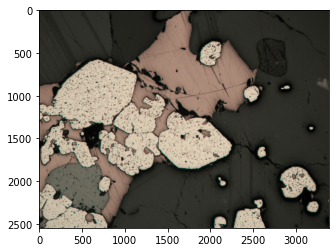

In [73]:
REFERENCE_CS = Color(ref_colors / 255, sRGB)

ccm = color_calibration(input_colors / 255, REFERENCE_CS, colorspace = sRGB)

new_input_image = ccm.infer_image(input_image)

cv.imwrite(input_file_name + '_updated.jpg', cv.cvtColor(new_input_image, cv.COLOR_RGB2BGR))

plt.imshow(new_input_image)